<img src="../_static/Gamma_Facet_Logo_RGB_LB.svg" width="500" style="padding-bottom: 70px; padding-top: 70px; margin: auto; display: block">

# Classification with FACET

***

**Robust and impactful Data Science with FACET**

FACET enables us to perform a number of critical steps in best practice Data Science work flow easily, efficiently and reproducibly:

1. Create a robust pipeline for learner selection using LearnerRanker and cross-validation.

2. Enhance our model inspection to understand drivers of predictions using local explanations of features via [SHAP values](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) by applying a novel methodology that decomposes SHAP values into measures of synergy, redundancy, and independence between each pair of features.

3. Quickly apply historical simulation to gain key insights into feature values that minimize or maximize the predicted outcome.

***

**Context**

Prediabetes is a treatable condition that leads to many health complications and eventually type 2 diabetes. Identification of  individuals at risk of prediabetes can improve early intervention and provide insights into those interventions that work best.
Using a cohort of healthy (n=2847) and prediabetic (n=1509) patients derived 
from the [NHANES 2013-14 U.S. cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013) we aim to create a classifier for prediabetes. For further details on data sources, definitions and the study cohort please see the Appendix ([Data source and study cohort](#Data-source-and-study-cohort)).

Utilizing FACET we will do the following:

- create a pipeline to find identify a well-performing classifier
- perform model inspection and simulation to gain understanding and insight into key factors predictive of prediabetes.

***

**Tutorial outline**

1. [Preprocessing and initial feature selection](#Preprocessing-and-initial-feature-selection)
2. [Selecting a learner using FACET ranker](#Selecting-a-learner-using-FACET-ranker)
3. [Using the FACET inspector for model inspection](#Using-the-FACET-inspector-for-model-inspection)
4. [FACET univariate simulator: the impact of waist to height ratio](#FACET-univariate-simulator:-the-impact-of-waist-to-height-ratio)
5. [Summary](#Summary)
6. [What can you do next?](#What-can-you-do-next?)
7. [Appendix](#Appendix)

In [2]:
# standard imports
import numpy as np
import pandas as pd
from scipy.linalg import toeplitz
import matplotlib.pyplot as plt
import shap

# couple of extra packages to make EDA easier
import seaborn as sns
from tableone import TableOne

# sklearn
from sklearn.compose import make_column_selector
from sklearn.model_selection import RepeatedKFold

# FACET imports
from facet import Sample
from facet.inspection import LearnerInspector
from facet.selection import LearnerRanker, LearnerGrid
from facet.validation import BootstrapCV
from facet.simulation.partition import ContinuousRangePartitioner
from facet.simulation import UnivariateProbabilitySimulator
from facet.simulation.viz import SimulationDrawer
from facet.crossfit import LearnerCrossfit

# sklearndf imports
from sklearndf.pipeline import PipelineDF, ClassifierPipelineDF
from sklearndf.classification import RandomForestClassifierDF
from sklearndf.classification.extra import LGBMClassifierDF
from sklearndf.transformation import (
    ColumnTransformerDF,
    OneHotEncoderDF,
    SimpleImputerDF,
)
from sklearndf.transformation.extra import BorutaDF

# pytools
from pytools.viz.dendrogram import DendrogramDrawer, LinkageTree
from pytools.viz.matrix import MatrixDrawer

# Preprocessing and initial feature selection

First we need to load our prediabetes data and create a simple preprocessing pipeline. For those interested some initial EDA can be found in the Appendix ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))).

In [4]:
# load the prepared dataframe
prediab_df = pd.read_csv('sphinx/source/tutorial/pre_diab_nhanes.csv')

# create a couple of new interesting features
prediab_df['SBP_to_DBP'] = prediab_df['Average_SBP']/prediab_df['Average_DBP']
prediab_df['Waist_to_hgt'] = prediab_df['Waist_Circumference']/prediab_df['Standing_Height']

# make clear based on dtypes these two features are categorical
prediab_df['General_health'] = prediab_df['General_health'].astype('object')
prediab_df['Healthy_diet'] = prediab_df['Healthy_diet'].astype('object')

# have a look
prediab_df.head()

,Age,Gender,Waist_Circumference,Weight,Standing_Height,BMI,Average_SBP,Average_DBP,HDL_Cholesterol,Total_Cholesterol,...,Osmolality,Sodium,Potassium,Gamma_glutamyl_transferase,Calcium,Alanine_aminotransferase,Aspartate_aminotransferase,Pre_diab,SBP_to_DBP,Waist_to_hgt
0,73.0,2.0,NaN,52.0,162.4,19.7,137.333333,86.666667,85.0,201.0,...,290.0,142.0,4.1,31.0,10.0,28.0,36.0,1,1.584615,NaN
1,56.0,1.0,123.1,105.0,158.7,41.7,157.333333,82.000000,38.0,226.0,...,287.0,143.0,3.3,22.0,9.3,16.0,24.0,0,1.918699,0.775677
2,61.0,2.0,110.8,93.4,161.8,35.7,122.666667,80.666667,58.0,168.0,...,281.0,140.0,3.9,17.0,9.9,21.0,20.0,1,1.520661,0.684796
3,56.0,2.0,85.5,61.8,152.8,26.5,122.000000,72.666667,59.0,278.0,...,277.0,139.0,4.0,21.0,9.5,24.0,23.0,0,1.678899,0.559555
4,65.0,1.0,93.7,65.3,172.4,22.0,141.333333,77.333333,79.0,173.0,...,281.0,140.0,4.8,24.0,9.5,20.0,29.0,0,1.827586,0.543503


Using FACET we create a sample object, which carries information used in other FACET functions.

In [5]:
# create a FACET sample object
prediab = Sample(
    observations=prediab_df,
    features=prediab_df.drop(columns=['Pre_diab']).columns,
    target='Pre_diab'
)

Next we create a minimum preprocessing pipeline which based on our initial EDA ([Exploratory Data Analysis](#Exploratory-Data-Analysis-(EDA))) needs to address the following:

1. Simple imputation for missing values in both continuous and categorical features
2. One-hot encoding for categorical features

In [6]:
# for categorical features we will use the mode as the imputation value and also one-hot encode
preprocessing_categorical = PipelineDF(
    steps=[
        ("imputer", SimpleImputerDF(strategy="most_frequent", fill_value="<na>")), 
        ("one-hot", OneHotEncoderDF(sparse=False, handle_unknown="ignore"))
    ]
)

# for numeric features we will impute using the median
preprocessing_numerical = SimpleImputerDF(strategy="median")

# put the pipeline together
preprocessing = ColumnTransformerDF(
    transformers=[
        ('categorical', preprocessing_categorical, make_column_selector(dtype_include=object)),
        ('numerical', preprocessing_numerical, make_column_selector(dtype_include=np.number))
    ]
)

Next is some initial feature selection using Boruta, a recent approach shown to have quite good performance. The Boruta algorithm removes features that are no more predictive than random noise. If you are interested further please see this [article](https://www.jstatsoft.org/article/view/v036i11).

For settings, a max_depth of between 3 and 7 is typically recommended. However, as this depends on the number of features and the complexity of interactions one could also explore the sensitivity of feature selection to this parameter.

In [7]:
# create the pipeline for Boruta
boruta_pipeline = PipelineDF(
    steps=[
        ('preprocess', preprocessing),
        ('boruta', BorutaDF(
            estimator=RandomForestClassifierDF(max_depth=5, n_jobs=-3, random_state=42), 
            n_estimators="auto", 
            random_state=42,
            verbose=False
        )),
    ]
)

# run feature selection using Boruta and report those selected
boruta_pipeline.fit(X=prediab.features, y=prediab.target)
selected = boruta_pipeline.features_out.to_list()
selected

['Age',
 'Waist_Circumference',
 'Weight',
 'Standing_Height',
 'BMI',
 'Average_SBP',
 'Average_DBP',
 'HDL_Cholesterol',
 'Total_Cholesterol',
 'High_BP',
 'Vigorous_rec_activity',
 'RBC_count',
 'Uric_acid',
 'Osmolality',
 'Potassium',
 'Gamma_glutamyl_transferase',
 'Alanine_aminotransferase',
 'SBP_to_DBP',
 'Waist_to_hgt']

Boruta identified 19 features (out of a potential 47) that we will retain for classification. Note that this feature selection process could be included in a general preprocessing pipeline, however due to the computation involved, we have utilized Boruta here as an initial one-off processing step to narrow down the features for our classifier development.

In [8]:
# update FACET sample object to only those features Boruta identified as useful
prediab = prediab.keep(selected)

# Selecting a learner using FACET ranker

FACET implements Bootstrap CV which uses resampling to create a training set. This re-sampling procedure is repeated many times to get an estimate of average model performance and the variability of that performance. This is an important extension of the native scikit-learn cross-validators which do not support sampling with replacement.

The following learners and hyper-parameter ranges will be assessed using 10 repeated 5-fold cross-validation:


1. **Random forest**: with hyper-parameters
    - max_leaf_nodes: [5, 10, 20]
    - n_estimators: [50, 100, 200]  
  
  
2. **Light gradient boosting**: with hyper-parameters
    - max_depth: [5, 10]
    - num_leaves: [20]
    - learning_rate: [0.2, 0.1]
    - subsample: [0.7]
    - feature_fraction:[0.8]

Note if you want to see a list of hyper-parameters you can use `classifier_name().get_params().keys()` where `classifier_name` could be for example `RandomForestClassifierDF` and if you want to see the default values, just use `classifier_name().get_params()`.

Finally, for this exercise we will use AUC as the performance metric for scoring and ranking our classifiers. Note that ranking uses the average performance minus two times the standard deviation, so that we take into account both the average performance and variability when selecting a classifier.

In [9]:
# 1. Random forest learner
rf_pipeline=ClassifierPipelineDF(
    preprocessing=preprocessing,
    classifier=RandomForestClassifierDF(random_state=42)   
)
rf_grid=LearnerGrid(
    pipeline=rf_pipeline,
    learner_parameters={'max_depth': [4, 8, 16, 32],
                        'n_estimators': [200, 500]}
)

# 2. Light gradient boosting learner
gb_pipeline=ClassifierPipelineDF(
    preprocessing=preprocessing,
    classifier=LGBMClassifierDF(random_state=42)
)
gb_grid=LearnerGrid(
    pipeline=gb_pipeline,
    learner_parameters={'max_depth': [5, 10],
                        'num_leaves': [20],
                        'learning_rate': [0.2, 0.1],
                        'subsample': [0.7],
                        'feature_fraction':[0.8]}
)

In [10]:
# instigate ranker and fit using 10-fold CV
ranker=LearnerRanker(
    grids=[rf_grid, gb_grid],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(prediab)

In [11]:
# Let's look at performance
print(ranker.summary_report(5))

Rank  1: RandomForestClassifierDF, ranking_score=    0.702, scores_mean=    0.734, scores_std=   0.0163, parameters={classifier__max_depth=8,classifier__n_estimators=500}

Rank  2: RandomForestClassifierDF, ranking_score=    0.701, scores_mean=    0.733, scores_std=   0.0162, parameters={classifier__max_depth=8,classifier__n_estimators=200}

Rank  3: RandomForestClassifierDF, ranking_score=    0.696, scores_mean=    0.727, scores_std=   0.0153, parameters={classifier__max_depth=4,classifier__n_estimators=500}

Rank  4: RandomForestClassifierDF, ranking_score=    0.696, scores_mean=    0.727, scores_std=   0.0153, parameters={classifier__max_depth=4,classifier__n_estimators=200}

Rank  5: RandomForestClassifierDF, ranking_score=    0.694, scores_mean=    0.729, scores_std=   0.0175, parameters={classifier__max_depth=32,classifier__n_estimators=500}



We can see based on our learner ranker, we have selected a Random Forest algorithm that achieved a mean ROC AUC of 0.73 with a SD of 0.02.

# Using the FACET inspector for model inspection

The [SHAP approach](http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions) has become the standard method for model inspection. SHAP values are used to explain the additive contribution of each feature to the prediction for a given observation. SHAP values are computed for every feature and observation.

The FACET `LearnerInspector` computes these SHAP values for each bootstrap resample using the best model identified by the `LearnerRanker`. The FACET `LearnerInspector` then provides advanced model inspection through new SHAP-based summary metrics for understanding feature redundancy and synergy.

Briefly, the definitions are as follows:

1. **Redundancy** represents how much information is shared between two features contributions to model predictions. In our example we might expect redundancy between BMI and waist circumference as a higher BMI will tend to lead to a larger waist circumference and vice versa. This means just knowing one or the other is likely to provide similar predictive performance.
2. **Synergy** represents how much the combined information of two features contributes to the model predictions. In our example we could hypothesize that knowing both gender and BMI provides greater accuracy in predicting prediabetes risk than either alone. 

SHAP values from the `LearnerInspector` can also be used with the SHAP package plotting functions for sample and observation level SHAP visualizations, such as SHAP distribution plots, dependency plots, force plots and waterfall plots.

In [12]:
# run inspector
inspector=LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(crossfit=ranker.best_model_crossfit)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed: 26.5min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed: 30.8min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed: 73.1min
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed: 96.9min
[Parallel(n_jobs=-3)]: Done  29 tasks      | elapsed: 119.4min
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed: 145.8min
[Parallel(n_jobs=-3)]: Done  45 out of  50 | elapsed: 161.0min remaining: 17.9min
[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed: 170.4min finished


In [13]:
# obtain FACET feature importance, as well as synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()
dd_redundancy = inspector.feature_redundancy_linkage()

# also let's get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
rf_pipeline.preprocessing.fit(X=prediab.features)
X_train = rf_pipeline.preprocessing.transform(X=prediab.features)
X_train = X_train.reset_index()[prediab.features.columns]

## Feature importance

Feature importance has many different ways of being measured. Here we utilize the FACET implementation based on the `LearnerInspector`. Each feature is ranked according to the mean SHAP value for that feature. This plot is paired with a standard SHAP distribution plot for features to see if there is any directional tendency for the associations.

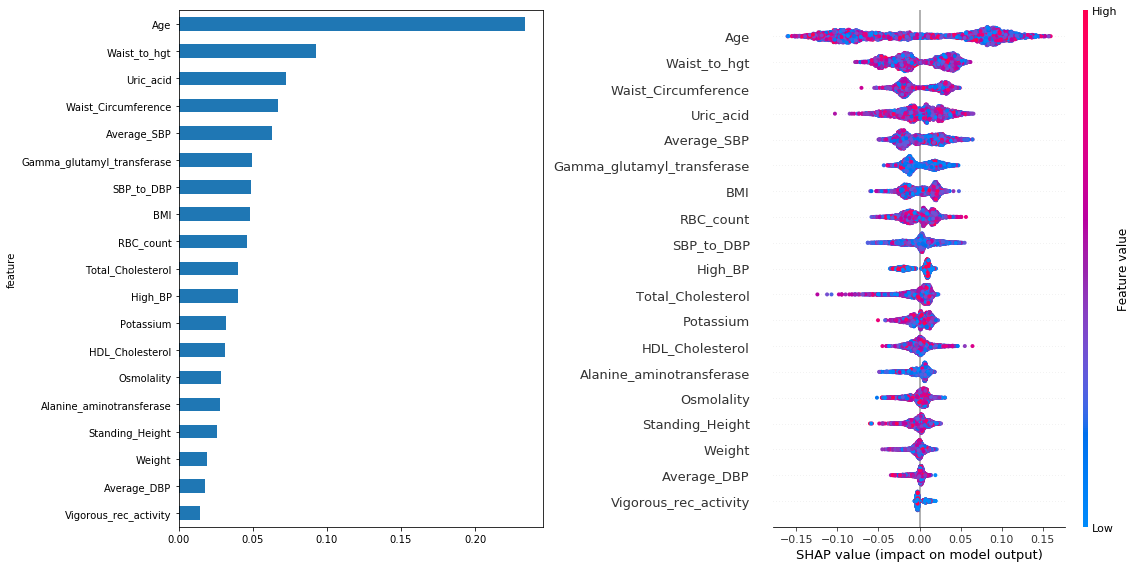

In [14]:
# FACET feature importance
plt.subplot(1, 2, 1)
f_importance.sort_values().plot.barh()

# standard SHAP summary plot using the SHAP package
plt.subplot(1, 2, 2)
shap.summary_plot(shap_values, X_train, show=False, plot_size=(16.0, 8.0))
plt.tight_layout()

Based on the feature importances we can see the top five features are age, waist to height ratio, waist circumference, uric acid and average systolic blood pressure. Inspection of the SHAP value distributions does not provide any indication of a general direction of association for any features. 

## Synergy and redundancy

Synergy and redundancy are part of the key extensions FACET makes to using SHAP values to understand model predictions.

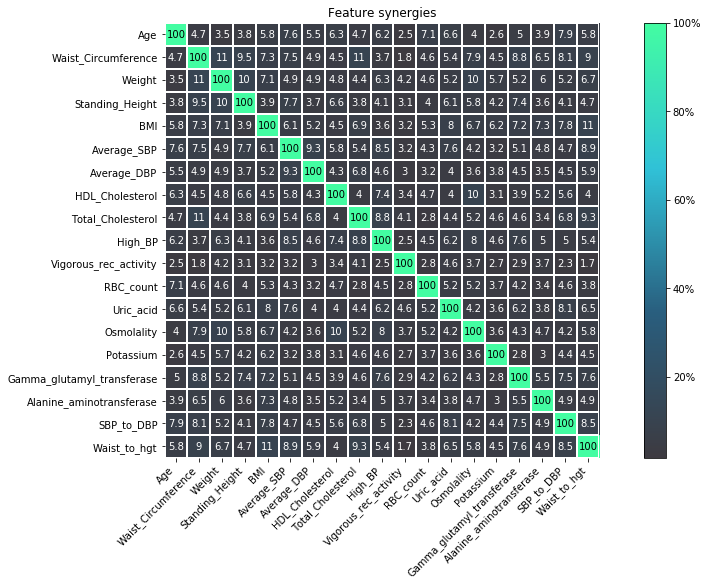

In [15]:
# synergy heatmap
MatrixDrawer(style="matplot%").draw(synergy_matrix, title="Feature synergies")

*Synergy represents the degree to which one feature combines with another to generate a prediction.* In the above heatmap we can see the off-diagonal values never exceed 10%. This would suggest that no two features have a strong degree of synergy.

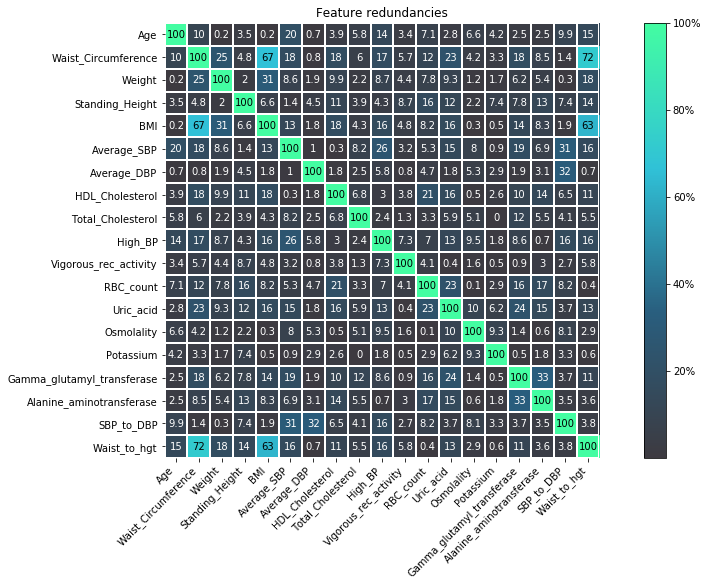

In [16]:
# redundancy heatmap
MatrixDrawer(style="matplot%").draw(redundancy_matrix, title="Feature redundancies")

*Redundancy represents the shared information between two features.* In the above heatmap we can see a values > 60% for (`Waist_circumference` and `Waist_to_hgt`), (`Waist_circumference` and `BMI`) and (`BMI` and `Waist_to_hgt`). Another way to look at redundancy is using a dendrogram.

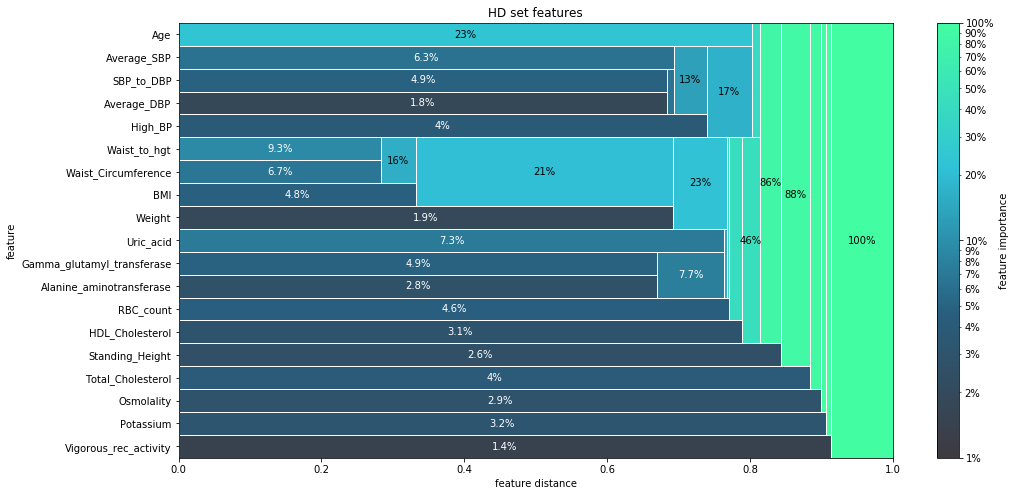

In [17]:
# redundancy dendrogram
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

The dendrogram represents the extent of clustering among the features. Taking the `Waist_circumference` and `Waist_to_hgt` features which have the highest redundancy, we can see these features cluster together earliest in the dendrogram. Ideally we want to see features only start to cluster as close to the right-hand side of the dendrogram as possible. This implies all features in the model are contributing uniquely to our predictions.

**What might we infer from the above information?**

1. BMI, waist circumference and waist to height ratio form a small cluster of redundant features. This seems reasonable:
    * waist circumference is included in the calculation of waist to height ratio
    * we might expect BMI to capture similar information about excess body mass as higher waist circumference and waist to height ratio
2. We saw little synergy between features. We might have expected apriori to find some interesting synergies between diet, exercise, sleep and body composition. Of course, the model needs to identify these relationships from them to be reflected in the synergy metric(s).

**What action(s) might we take?**

1. Given the redundancy that appears between BMI, waist circumference and waist to height ratio, we could look to eliminate one or two of these features from the model.

## Removing redundant features

Recall the redundancy dendogram above where we saw a clear cluster of features with redundancy; `Waist_to_hgt`, `BMI`, and `Waist_Circumference`.

- assess if the features of the model are unique, i.e. not redundant with other features
- decide which features to discard, combine, or modify to increase the uniqueness of important features in the model

Before we proceed to looking at SHAP values for individual predictions and perform a univariate simulation, let's eliminate two partially redundant features - we will choose to keep `Waist_to_hgt` ratio and drop `BMI` and `Waist_Circumference`. 

In [18]:
# drop redundant features from our FACET sample object
prediab_new = prediab.drop(['BMI', 'Waist_Circumference'])

In [19]:
# re-run ranker without redundant features
ranker = LearnerRanker(
    grids=[rf_grid, gb_grid],
    cv=RepeatedKFold(n_splits=5, n_repeats=10, random_state=42),
    n_jobs=-3,
    scoring='roc_auc'
).fit(prediab_new)

# run inspector
inspector = LearnerInspector(
    n_jobs=-3,
    verbose=10,
).fit(
    crossfit=ranker.best_model_crossfit
)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done   1 tasks      | elapsed: 12.9min
[Parallel(n_jobs=-3)]: Done   6 tasks      | elapsed: 13.5min
[Parallel(n_jobs=-3)]: Done  13 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-3)]: Done  20 tasks      | elapsed: 50.9min
[Parallel(n_jobs=-3)]: Done  29 tasks      | elapsed: 65.0min
[Parallel(n_jobs=-3)]: Done  38 tasks      | elapsed: 88.7min
[Parallel(n_jobs=-3)]: Done  45 out of  50 | elapsed: 102.6min remaining: 11.4min
[Parallel(n_jobs=-3)]: Done  50 out of  50 | elapsed: 109.7min finished


In [20]:
# obtain FACET feature importance, as well as synergy and redundancy matrices
f_importance = inspector.feature_importance()
redundancy_matrix = inspector.feature_redundancy_matrix()
synergy_matrix = inspector.feature_synergy_matrix()
dd_redundancy = inspector.feature_redundancy_linkage()

# also get some info for standard SHAP plots!
shap_values = inspector.shap_values().to_numpy()
rf_pipeline.preprocessing.fit(X=prediab_new.features)
X_train = rf_pipeline.preprocessing.transform(X=prediab_new.features)
X_train = X_train.reset_index()[prediab_new.features.columns]

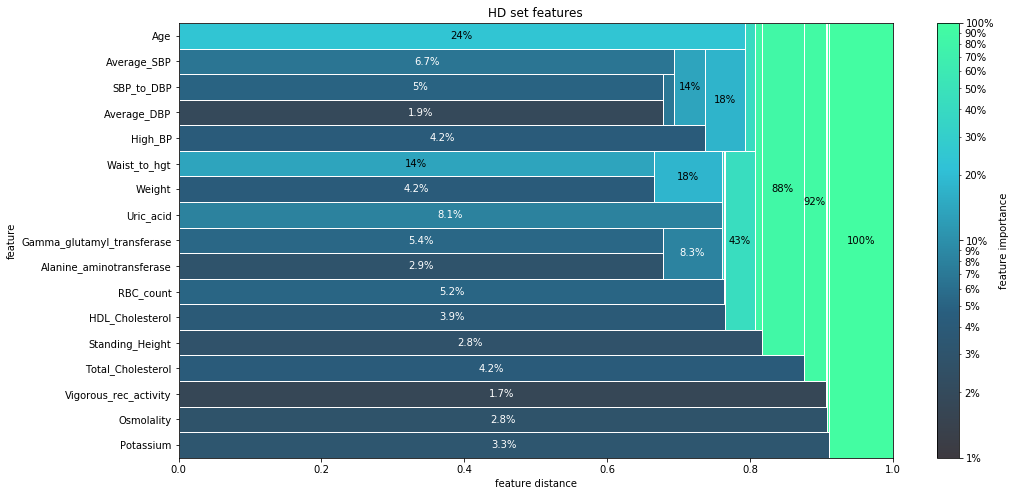

In [21]:
# redundancy dendogram
DendrogramDrawer().draw(title="HD set features", data=dd_redundancy)

Now with the removal of `BMI` and `Waist_Circumference` we can see the feature clustering starts much further to the right.

## Individual contributions to predictions

With SHAP values we can also look at how features contribute to individual predictions, so let us look at a patient at high risk of prediabetes using Waterfall plots. Note a similar understanding could be obtained from looking at force plots which also allows for a logit option to present probabilities.
For example: `shap.force_plot(base_value=base_value, shap_values=shap_values[1517,:], features=X_train.iloc[1517,:].round(2), matplotlib=True)`

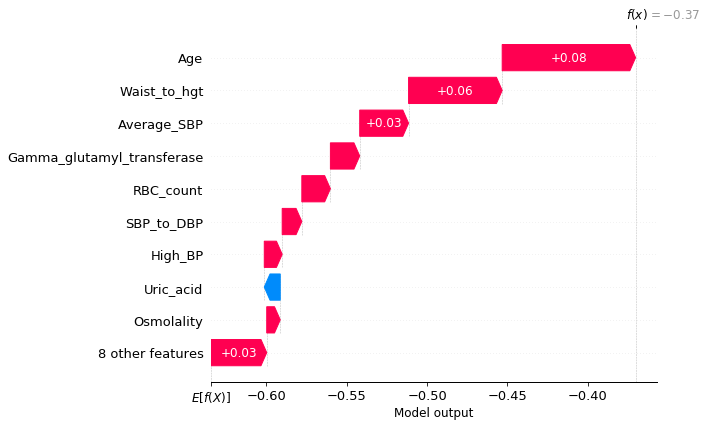

In [27]:
# waterfall plot to understand individual predictions
base_value = np.log(prediab_new.target.mean()/(1-prediab_new.target.mean()))
shap.waterfall_plot(base_value, shap_values[1517,:], feature_names=X_train.columns.values, max_display=10, show=True)

In [26]:
# get feature values for context of top three contributors to risk
pd.concat([X_train[['Age', 'Waist_to_hgt', 'Uric_acid']].iloc[1517,:],
           X_train[['Age', 'Waist_to_hgt', 'Uric_acid']].mean()],
          axis = 1)

,1517,0
feature_out,,
Age,68.000000,47.044536
Waist_to_hgt,0.752142,0.580660
Uric_acid,7.800000,5.386341


Based on the waterfall plot for this patient we can see the largest contributions to increased risk of prediabetes are a higher than average age, waist to height ratio, and uric acid levels.

# FACET univariate simulator: the impact of waist to height ratio

The second advantage offered by FACET is the ability to quickly instigate and run univariate simulation. 
Simulation enables us to gain insight into what value(s) of this ratio might minimize the likelihood of prediabetes. Further, because FACET can use bootstrap cross validation, we can create a crossfit from our previous LearnerRanker best model to perform the simulation and to also quantify the uncertainty by using bootstrap confidence intervals.

In [28]:
boot_crossfit = LearnerCrossfit(
    pipeline=ranker.best_model.native_estimator,
    cv=BootstrapCV(n_splits=250, random_state=42),
    n_jobs=-3,
    verbose=2
).fit(sample=prediab_new)

[Parallel(n_jobs=-3)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-3)]: Done  29 tasks      | elapsed:   59.7s
[Parallel(n_jobs=-3)]: Done 150 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-3)]: Done 250 out of 250 | elapsed:  4.2min finished


In [29]:
# set-up and run a simulation
sim_feature = "Waist_to_hgt"
simulator = UnivariateProbabilitySimulator(crossfit=boot_crossfit, n_jobs=-1)
partitioner = ContinuousRangePartitioner()
univariate_simulation = simulator.simulate_feature(name=sim_feature, partitioner=partitioner)

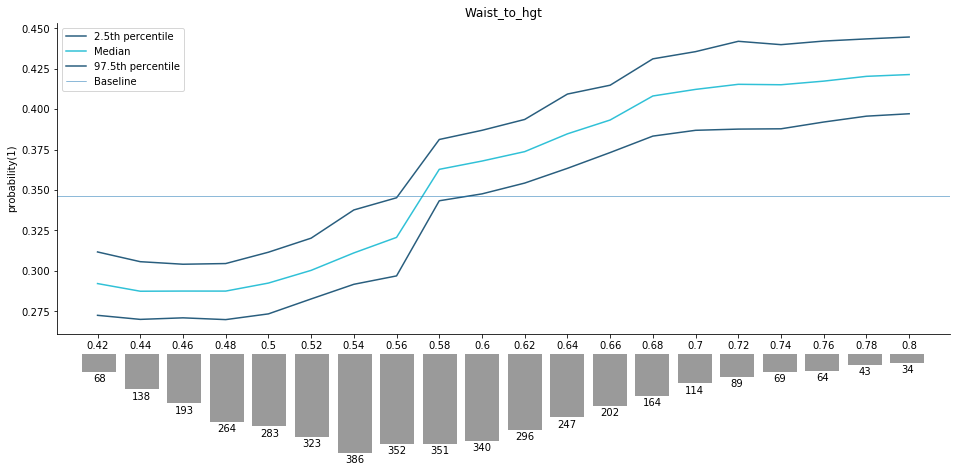

In [30]:
# visualize the results
SimulationDrawer().draw(data=univariate_simulation, title=sim_feature)

As we can see the simulation shows that higher waist to height ratios are associated with an increased risk of prediabetes. We could also suggest that keeping a persons waist to height ratio below 0.5 will reduce the likelihood of prediabetes from around 35% to 28%.

In [55]:
# can also get a print out of simulation results
SimulationDrawer("text").draw(data=univariate_simulation, title=sim_feature)

Waist_to_hgt

probability(1):

Baseline = 0.3464187327823691

Partition  2.5th percentile  Median     97.5th percentile
=========  ================  =========  =================
0.42               0.261      0.282              0.302   
0.44               0.261      0.282              0.301   
0.46               0.262      0.285              0.303   
0.48               0.262      0.285              0.304   
0.5                0.267      0.289              0.311   
0.52               0.274      0.297              0.321   
0.54               0.285      0.308              0.338   
0.56               0.293      0.318              0.35    
0.58               0.348      0.368              0.386   
0.6                0.351      0.372              0.392   
0.62               0.357      0.376              0.395   
0.64               0.363      0.382              0.403   
0.66               0.368      0.389              0.407   
0.68               0.375      0.397              0.421   
0.7       

# Summary

With the capabilities offered by FACET we were able to:

1. Identify a learner using bootstrap CV with performance comparable to models in the literature.
2. Utilize advanced the SHAP value capabilities (synergy and redundancy) to identify additional features that could be removed (i.e., BMi and waist circumference remvoed in favor of waist to height ratio) and whether or not any features had strong synergistic effects - which they did not.
3. Simulate the effect of changes in waist to height ratio on the likelihood of being prediabetic.

# What can you do next?

There are a number of next/alternative steps that could be taken:

1. Utilize methods to deal with class imbalance and see if it improves the model.
2. Adding more features! The NHANES data is a treasure trove of information.
3. Retain diabetic patients and convert it into a multi-class learning problem.
4. What would happen if we applied survey weights when constructing a learner?
5. Further investigation of feature engineering. One could also look at different sets of measurements such as the bio-profile and perform dimension reduction first via PCA or some other method.
6. Other learners such as SVC, LDA, Elastic-Net, CNN.
7. More sophisticated imputation for missing values: the assumption of MAR might not hold, as those with worse health and thus more at risk of prediabetes may be more likely not to disclose poor health characteristics. Methods enabled by IterativeImputer could be used or even KNNImputer. Also feature engineering could be done post imputation in the pipeline, so values such as ratios are consistent. 

# Appendix

## Data source and study cohort

**Introduction**  
Prediabetes is a treatable condition that leads to many health complications, including eventually type 2 diabetes. Prediabetes has become an epidemic worldwide and is increasing in prevalence. Due to being a largely asymptomatic condition, screening for prediabetes can be extremely challenging. However, early intervention, especially with lifestyle changes has been shown as effective in treating prediabetes. Accurate prediction/identification of those individuals at risk of prediabetes can improve early intervention and may provide insights into those interventions that work best. The current standard of care is a CDC prediabetes risk [screening tool](https://www.cdc.gov/diabetes/prevention/pdf/Prediabetes-Risk-Test-Final.pdf). 

**Data source**  
The dataset used in this tutorial is derived from the [National Health and Nutrition Examination Survey (NHANES) 2013-14 cross-sectional survey](https://wwwn.cdc.gov/nchs/nhanes/Search/DataPage.aspx?Component=Examination&CycleBeginYear=2013). In brief, NHANES collects demographic, socioeconomic, dietary, health, medical, dental, physiological and laboratory data on a nationally representative sample of noninstitutionalized, civilian United States residents. Please note the set-up for this data loosely follows the approach in [De Silva et al](https://pubmed.ncbi.nlm.nih.gov/31889178/).

**Patient cohort**  
In the NHANES data sub-sets of those surveyed may undergo a plasma glucose (FPG) test, oral glucose tolerance
test (OGTT), or have glycated hemoglobin (HbA1c) measured. Diabetic patients were defined as those with any of the following: FPG >= 126 mg/dl, OGTT > 200 mg/dl, HbA1c > 6.4% or a Doctor diagnosed diabetes. The created dataset contains selected information for 4356 patients aged 20 years or over who were not considered diabetic or who were not pregnant or suspected to be pregnant at the time of the survey.

**Learning target: prediabetes status**  
Using any of the available FPG, OGTT and HbA1c tests we defined patients as prediabetic where any of the following was satisfied: FPG 100–125 mg/dl, OGTT 140–200 mg/dl, or HbA1c 5.7–6.4%. Among this cohort 35% were pre-diabetic (n=1509).

**Initial features**  
The following tables provides an overview of the 37 features included in the example dataset.

|Instrument	|Data File Name (File)	| NHANES Field	| Description | Dataset name | Type |
| :-- | :-- | :-- | :-- | :-- | :-- |
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIDAGEYR|Age in years at screening|Age|Numeric|
|Demographics|Demographic Variables, Sample Weights (DEMO_H)|RIAGENDR|Gender|Gender| Categorical|
|Examination|Body Measures (BMX_H)|BMXWT|Weight (kg)|Weight|Numeric|
|Examination|Body Measures (BMX_H)|BMXHT|Standing Height (cm)|Standing_Height|Numeric|
|Examination|Body Measures (BMX_H)|BMXWAIST|Waist Circumference (cm)|Waist_Circumference|Numeric|
|Examination|Body Measures (BMX_H)|BMXBMI|Body Mass Index (kg/m^2)|BMI|Numeric|
|Examination|Blood Pressure (BPX_H)|BPXSY1 to 4|Systolic: Blood pres mm Hg|Average_SBP| Numeric|
|Examination|Blood Pressure (BPX_H)|BPXDI1 to 4|Diastolic: Blood pres mm Hg|Average_DBP| Numeric|
|Questionnaire|Blood Pressure & Cholesterol (BPQ_H)|BPQ020|Ever told you had high blood pressure|High_BP| Categorical|
|Questionnaire|Diet Behavior & Nutrition (DBQ_H)|DBQ700|How healthy is the diet|Healthy_diet| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ175A|Family history|Family_hist_diab| Categorical|
|Questionnaire|Diabetes (DIQ_H)|DIQ172|Feel could be at risk for diabetes|Feel_at_risk_diab| Categorical|
|Questionnaire|Current Health Status (HSQ_H)|HSD010|General health condition|General_health| Categorical|
|Questionnaire|Medical Conditions (MCQ_H)|MCQ080|Doctor ever said you were overweight|Told_overweight| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ605|Vigorous work activity|Vigorous_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ620|Moderate work activity|Moderate_work_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ635|Walk or bicycle|Walk_or_bicycle| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ650|Vigorous recreational activities|Vigorous_rec_activity| Categorical|
|Questionnaire|Physical Activity (PAQ_H)|PAQ665|Moderate recreational activities|Moderate_rec_activity| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLD010H|How much sleep do you get (hours)?|Sleep_hours| Numeric|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ050|Ever told doctor had trouble sleeping?|Trouble_sleeping| Categorical|
|Questionnaire|Sleep Disorders (SLQ_H)|SLQ060|Ever told by doctor have sleep disorder?|Sleep_disorder| Categorical|
|Questionnaire|Weight History (WHQ_H)|WHQ070|Tried to lose weight in past year|Tried_weight_loss_past_year| Categorical|
|Laboratory|Cholesterol HDL (HDL_H)|LBDHDD|Direct HDL-Cholesterol (mg/dL)|HDL_Cholesterol| Numeric|
|Laboratory|Cholesterol Total (TCHOL_H)|LBXTC|Total Cholesterol(mg/dL)|Total_Cholesterol| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXWBCSI|White blood cell count (1000 cells/uL)|WBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXRBCSI|Red blood cell count (million cells/uL)|RBC_count| Numeric|
|Laboratory|Complete Blood Count (CBC_H)|LBXHCT|Hematocrit (%)|Hematocrit| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSTR|Triglycerides (mg/dL)|Triglycerides| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSUA|Uric acid (mg/dL)|Uric_acid| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSOSSI|Osmolality (mmol/Kg)|Osmolality| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSNASI|Sodium (mmol/L)|Sodium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSKSI|Potassium (mmol/L)|Potassium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSGTSI|Gamma glutamyl transferase (U/L)|Gamma_glutamyl_transferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSCA|Total calcium (mg/dL)|Calcium| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSATSI|Alanine aminotransferase ALT (IU/L)|Alanine_aminotransferase| Numeric|
|Laboratory|Biochemistry Profile (BIOPRO_H)|LBXSASSI|Aspartate aminotransferase AST (IU/L)|Aspartate_aminotransferase| Numeric|

## Exploratory Data Analysis (EDA)

Let's begin by doing some brief exploratory data anaylsis to assess the impact features might have on the likelihood someone is pre-diabetic and to also determine what will need to be addressed in a pre-processing pipeline.

In [ ]:
# load the prepared dataframe
prediab_eda = pd.read_csv('sphinx/source/tutorial/pre_diab_nhanes.csv')
prediab_eda.head()

We might also consider some rudimentary feature engineering as well, such as the ratio of waist circumference to height or the ratio of systolic to diastolic blood pressure. Let's create these two features as well.

In [ ]:
prediab_eda['SBP_to_DBP'] = prediab_eda['Average_SBP']/prediab_eda['Average_DBP']
prediab_eda['Waist_to_hgt'] = prediab_eda['Waist_Circumference']/prediab_eda['Standing_Height']
prediab_eda.head()

In [ ]:
# First a quick look at features overall - remove .head() to see all features
prediab_eda.describe().T

In [ ]:
# Missingness
miss_count = prediab_eda.isna().sum()
miss_pct = miss_count[miss_count>0]/len(prediab_df)
miss_pct.sort_values().plot.barh()

In [ ]:
# those variables that are complete
miss_count[miss_count==0]/len(prediab_eda)

In [ ]:
# Look at correlations
# Heatmap view
df_cor = prediab_eda.corr()
sns.heatmap(df_cor, 
            xticklabels=df_cor.columns,
            yticklabels=df_cor.columns)

In [ ]:
# Let's do a table comparing features by the target
categorical = ['Gender', 'High_BP', 'Trouble_sleeping', 'Sleep_disorder', 'Told_overweight', 'General_health',
               'Family_hist_diab', 'Feel_at_risk_diab', 'Vigorous_work_activity', 'Moderate_work_activity',
               'Walk_or_bicycle', 'Vigorous_rec_activity', 'Moderate_rec_activity', 'Tried_weight_loss_past_year',
               'Healthy_diet']

mytable = TableOne(prediab_eda,
                   columns=prediab_df.columns.drop('Pre_diab').to_list(),
                   categorical=categorical,
                   groupby='Pre_diab',
                   pval=True,
                   remarks=False,
                   overall=False)
print(mytable)

In [ ]:
# KDE plots by prediabetes status as well for those continuous features
distn_vars = ['Age', 'Waist_Circumference', 'Weight', 'Standing_Height', 'BMI', 'Average_SBP', 'Average_DBP',
              'HDL_Cholesterol', 'Total_Cholesterol', 'Sleep_hours',  'WBC_count', 'RBC_count', 'Hematocrit',
              'Triglycerides', 'Uric_acid', 'Osmolality', 'Sodium', 'Potassium', 'Gamma_glutamyl_transferase',
              'Calcium', 'Alanine_aminotransferase', 'Aspartate_aminotransferase', 'SBP_to_DBP', 'Waist_to_hgt']

df_kde = pd.melt(prediab_eda[distn_vars + ['Pre_diab']], 'Pre_diab', distn_vars)
g = sns.FacetGrid(df_kde, col="variable", hue="Pre_diab", col_wrap=5, sharex=False, sharey=False)
g.map(sns.kdeplot, "value", shade=True)
plt.show()

**Quick EDA summary:**

Missingness

- Our target and 10 features were complete.
- The other 29 features had levels of missing ranging from 0.02% to 11.5%, and 22 of the 29 were <3%.
- Most extreme cases of missingness were for tried weight loss in the past year (11.5%) and general health (7.8%).

Correlations

- There is a wide range of correlation among features, where in particular we can see that for example RBC count, hematocrit and standing height are all moderately negatively correlated with gender (i.e., females are shorter), and that body measurements for weight, height, BMI, and waist circumference are all strongly positively correlated. 

Associations

- Some features already appear to not to be strongly associated based on univariate tests, such as: average DBP, trouble sleeping, vigorous work activity, moderate work activity, tried weight loss in the past year, healthy diet, WBC count, and calcium levels.
- Features associated with an increased risk of prediabetes include: older age, being male, increased waist circumference, decreased standing height, increased weight, increased BMI, increased average SBP, lower HDL cholesterol, increased total cholesterol, having high BP, increased sleep hours, having a sleep disorder, being told you are overweight, poorer general health, family history of diabetes, feeling at risk for diabetes, reduced walking or cycling, less vigorous or moderate recreational activity, higher RBC count, higher hematocrit, increased triglycerides, increased uric acid, higher osmolality, increased sodium, increased potassium, increased gamma glutamyl transferase, increased alanine aminotransferase, increased aspartate aminotransferase, increased SBP to DBP ratio, increased waist to height ratio.

Distributions of numeric features

- Many of the continuous features have been flagged as potentially non-normal/multi-modal and with potential outliers. This can be seen in the plots where many biomarkers have positive skewed distributions and in the case of sodium, some modality which could also be related to measurement.